# Initiate Setup

Load necessary packages.

In [ ]:
import pandas as pd # for data transformations

pd.set_option('display.precision', 10)

I'm using Youtube video data I extracted for one of my old university projects, containing video metadata and basic stats. This made possible through the __[Youtube Data API](https://developers.google.com/youtube/v3/getting-started)__. You can access the dataset __[here](https://kaggle.com/datasets/25549e0922bc57063216b8d2df47682bf44f45df90f321ff7bfebea474f75008)__

In [ ]:
df = pd.read_csv('video_channel_data.csv')

In [ ]:
df.head()

# Introduction

## Reductive crash course on data types on structured data

What are categorical variables?

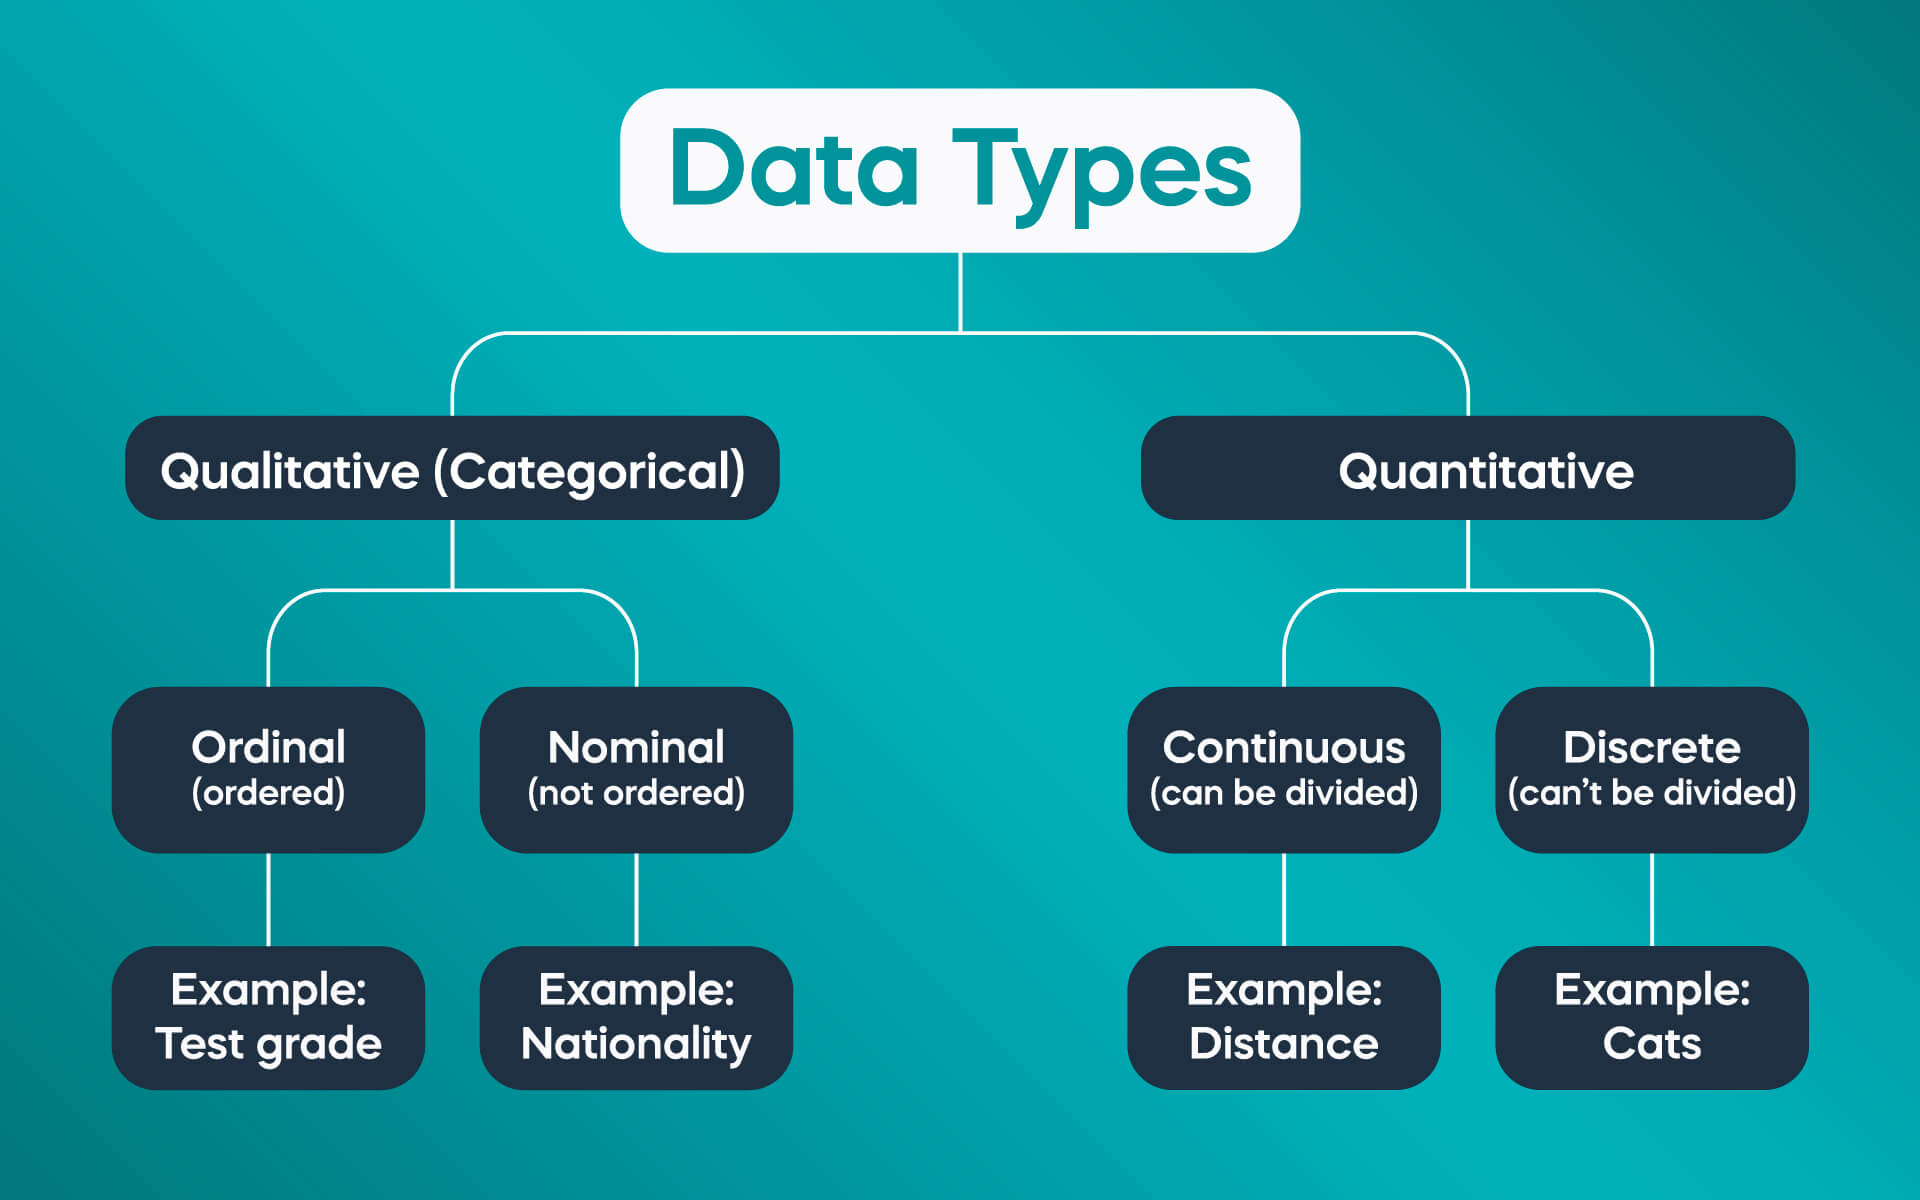

Source: [__[365 Data Science](https://365datascience.com/trending/data-types-complete-guide/)__]

Structured Data can be thought of as two types: numeric (integers, floats) and categorical (strings, booleans*). Categorical variables are either nominal (unordered ex. colours: red, blue, yellow) or ordinal (good, better, best). Some cases like dates (i.e. temporal data) can be represented as either a category or a number, depending on the application (i.e. if you're using the variable as a category like days of the week or you're using difference in time as the variable like timedelta).

Mathematical operations (+ - / *) don't make much sense with nominal categorical variables. How do we add or subtract cats and dogs? 

Ordinal variables can accept mathematical operations, __but__ we need to consider if the order is dictated by a fixed interval or a subjective one. Ex: __good__ is how much better than __better__?

*Note: booleans can also do math as they can be treated as 1 if true and 0 if false)

## Why does this matter?

A lot of machine learning techniques (ex. linear methods like regression, support vector machines, and neural networks) use mathematical operations to generate predictions. Sometimes these methods when applied directly to categorical variables yield fairly good results; however, _sometimes_ is unreliable. 

Because math doesn't fully make sense when we perform them on certain categorical variables, we need to consider ways to either:
- transform categoricals into numerics, or
- use techniques/packages/frameworks that can use categoricals directly

# Looking at the data (Exploratory Analysis)

Let's say we want to predict the number of views a video will get.

## Categories mistaken for numeric

We can see there are columns here already marked as potential categorical variables through the __object__ type, but some categories like __category_id__ is written as an __int__ because it looks like a number. 

In [ ]:
df.dtypes

We can cast category_id as a category object or a string object depending on what we want to do. For now, I just want to see it as a category.

In [ ]:
df['category_id'] = df['category_id'].astype('category')

In [ ]:
df.dtypes

## Unique strings

I find unique values to be an exploratory checkpoint for categorical variables, because you can find highly unique variables (high cardinality), which would make it hard for the machine to learn meaningful patterns (ex. overfitting every category). Personally, if the variable has over 80% of its values as unique for the whole dataset, I find it to be something to be cautious about. 

For me to examine this, I create a simple summary dataframe using a list of tuples.

In [ ]:
summary = []
headers = ['column', 'uniques', 'percent_unique']

In [ ]:
for col in df.columns:
    uniques = df[col].nunique()
    summary.append((col, uniques, uniques*100/len(df)))

summary_df = pd.DataFrame(summary, columns=headers)

In [ ]:
summary_df

- video_id is the unique identifier for the videos, and each observation in this dataset, so it's expected that it's 100% unique. A lot of the other string-based data like titles and descriptions are also highly unique.
- Numeric values are also expected to be highly unique
- Categories like category_id and topic_categories are expected to have low cardinality (low uniques) because the categories are repeatedly used across many observations. 

__What does this mean for us?__
- video_id can't be used as a feature.
- Either channel_id or channel_title can be used as a potential feature.
- video_title, video_description, and video_tags have opportunities to be engineered into useable features.
- There are plenty of other feature engineering opportunities for other columns.

__Other notes__
- view_count, like_count, and comment_count are already ruled out as potential features because they're more of outcomes.
- pull_timestamp is a metadata field as it's just when I pulled in the data.

## Where's the correlation?
Usually, for numeric variables, we're able to draw correlation matrices showing variables that have high correlations with each other, which can indicate dependencies to be pruned to avoid overfitting. Because we're dealing with categorical variables, the same analysis is not afforded to us. However, we can use the [Predictive Power Score (PPS)](https://pypi.org/project/ppscore), which aims to answer similar questions.

One of the ways to do it is by running pairs of PPS for each feature combination, but for this exercise, we can just semantically remove dependencies and redundancies.

In [ ]:
import ppscore as pps

In [ ]:
# Check if one feature can predict a target
pps.score(df, 'channel_id', 'view_count')

Calculate the Predictive Power Score (PPS) for "x predicts y"
- The score always ranges from 0 to 1 and is data-type agnostic.
- A score of 0 means that the column x cannot predict the column y better than a naive baseline model.
- A score of 1 means that the column x can perfectly predict the column y given the model.
- A score between 0 and 1 states the ratio of how much potential predictive power the model achieved compared to the baseline model.

In [ ]:
# Check if one feature can predict another feature
pps.score(df, 'category_id', 'channel_id')

In [ ]:
# Check if any feature can predict another feature
pps.predictors(df, 'view_count').pivot(columns='y', index='x', values='ppscore')

In [ ]:
# Create a PPS matrix; Create smaller sample to demonstrate
df_sample = df[['channel_id', 'channel_title', 'video_title', 'category_id', 'view_count']]
pps.matrix(df_sample).pivot(columns='y', index='x', values='ppscore')

# Encoding Options

Let's take a look at our options for encoding structured categorical variables.

## Can we engineer first?

We can extract information from these column values first before encoding them to get more information. For example:
- getting the "age" of the video and the channel (today - pub date)
- number of video_tags (len) and topic_categories
- length of video_title and video_description
- language of the video_title

Other possibilities I won't cover in this demo:
- Get topics from the descriptions (can be via topic modelling)
- Check if certain keywords and tags are in descriptions

In [ ]:
# Get the age of the video
df['video_age'] = pd.Timestamp.today(tz='UTC') - pd.to_datetime(df['pub_date'])
df['video_age'] = df['video_age'].dt.days

# Get the age of the channel
df['channel_age'] = pd.Timestamp.today(tz='UTC') - pd.to_datetime(df['channel_pub_date'])
df['channel_age'] = df['channel_age'].dt.days

In [ ]:
# Get number of video_tags
df['video_tags'] = df['video_tags'].fillna('') # there were some videos that did not have tags
df['video_tags'] = df['video_tags'].str.replace('[','').replace(']','') # the column was formatted as a string
df['video_tags'] = df['video_tags'].apply(lambda x: x.split(', ')) # convert the string to a list
df['num_tags'] = df['video_tags'].str.len() # get the length

# If empty tags, assign zero
df.loc[df['video_tags'].astype('string') == "['']", 'num_tags'] = 0

In [ ]:
# Get number of topic_categories
df['topic_categories'] = df['topic_categories'].fillna('')
df['topic_categories'] = df['topic_categories'].str.replace('[','').replace(']','')
df['topic_categories'] = df['topic_categories'].apply(lambda x: x.split(', '))
df['num_categories'] = df['topic_categories'].str.len()

# If empty tags, assign zero
df.loc[df['topic_categories'].astype('string') == "['']", 'num_categories'] = 0

In [ ]:
# Get length of video title
df['len_title'] = df['video_title'].str.len()

# Get length of video description
df['len_desc'] = df['video_description'].str.len()

In [ ]:
# Get language of each video based on the title
from langdetect import detect # for language detection
df['language'] = df['video_title'].apply(detect)

### Cleanup

We can now remove the columns we don't plan to use as features in this exercise.

In [ ]:
df = df.drop(['video_id', # too unique
              'video_title', # already engineered
              'video_description', # already engineered
              'topic_categories', # already engineered
              'pub_date', # too unique
              'channel_pub_date', # already engineered
              'video_tags', # already engineered
              'branding_keywords', # poor quality
              'channel_title', # redundant with channel_id
              'title', # redundant with channel_title
              'description', # skip for now. doesn't seem relevant
              'custom_url', # redundant with channel identifiers
              'made_for_kids', # poor quality
             ], 
             axis=1)

Rearrange the columns to see features first (video and channel metadata) then potential targets (view metrics).

In [ ]:
features = [
    'channel_id',
    'category_id',
    'language',
    'country',
    'channel_view_count',
    'subscriber_count',
    'video_count',
    'video_age',
    'channel_age',
    'num_tags',
    'num_categories',
    'len_title',
    'len_desc'
]

target = [
    'view_count',
    #'like_count',
    #'comment_count'
]

In [ ]:
df_processed = df[features + target]
df_processed.head()

We're left with 4 categorical features that we can encode. Let's check our unique values again.

In [ ]:
summary = []
headers = ['column', 'uniques', 'percent_unique']

In [ ]:
for col in df_processed.columns:
    uniques = df_processed[col].nunique()
    summary.append((col, uniques, uniques*100/len(df)))

summary_df = pd.DataFrame(summary, columns=headers)

In [ ]:
summary_df

### Train-Test Split

Succeeding encoding methods may use a set of data to fit its encoding, so we need to make sure to fit only on training data to avoid looking into the future (data leakage).

In [ ]:
from sklearn.model_selection import train_test_split

We need a dataframe of X (features) and Y (targets). Let's say we're predicting view_count for now.

In [ ]:
X = df_processed[features]
Y = df_processed[target]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

## One Hot Encoding

One Hot Encoding creates a binary 0/1 column for __each value__ in the categorical variable, and maps it to that observation. If the observation originally had the column as the value, it is marked with a 1. In our case, it may be better to skip the channel_id when doing the one-hot encoding as it will create 339 new columns, but we can try it on language and category_id.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
# Initiate the encoder
onehot = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop=None)

In [ ]:
# have the encoder learn the language as categories
onehot.fit(x_train[['language']])

# set one-hot output as pandas dataframe
onehot.set_output(transform='pandas')

In [ ]:
# Transform the column into the 0/1 matrix for the training set and test set
onehot_train = onehot.transform(x_train[['language']])
onehot_test = onehot.transform(x_test[['language']])

### The result for each row should match the language it was originally assigned to.

In [ ]:
onehot_train.head()

In [ ]:
x_train.head()

### We can now append the 0/1 matrix to the main dataframe.

In [ ]:
x_train_onehot = pd.concat([x_train, onehot_train], axis=1)
x_test_onehot = pd.concat([x_test, onehot_test], axis=1)

In [ ]:
# drop the language column
x_train_onehot = x_train_onehot.drop('language', axis=1)
x_test_onehot = x_test_onehot.drop('language', axis=1)

In [ ]:
x_train_onehot.head()

In [ ]:
x_test_onehot.head()

__Pros__
- Its numeric form makes sense and makes it viable for mathematical operations

__Cons__
- Often inefficient when dealing with large datasets, especially with high cardinality (unique values) categorical variables.

__Other Notes__
- Null values will need to be handled beforehand (ex. imputation, filled in as its own category).

## Target Encoding

Target Encoding generally refers to the use of an aggregation of the target variable to inform the numeric value of a categorical value. This is often done using the mean, but some also use frequency aggregation.

In [ ]:
from sklearn.preprocessing import TargetEncoder

_Scikit-learn is more intricate with its target encoding:_

Each category is encoded based on a __shrunk estimate of the average target values__ for observations belonging to the category. The encoding scheme mixes the __global target mean with the target mean conditioned on the value of the category__. __[[source](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.TargetEncoder.html)]__

_Note on nulls for Scikit-learn's target encoder:_

TargetEncoder considers missing values, such as np.nan or None, as another category and encodes them like any other category. Categories that are not seen during fit are encoded with the target mean, i.e. target_mean_. __[[source](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.TargetEncoder.html)]__

In [ ]:
# Initiate the encoder with a target_type parameter set to continuous just to be explicit.
# There is a smoothing parameter which is like a shrinking parameter to avoid overfitting, but we'll keep it default for now.
target_encoder = TargetEncoder(target_type='continuous')

In [ ]:
# have the encoder learn the language as categories, and plug in the y values to be used for the 'aggregation'
target_encoder.fit(x_train[['language']], y_train)

# set output as pandas dataframe
target_encoder.set_output(transform='pandas')

In [ ]:
# Transform the column into an encoded column for the training set and test set
target_train = target_encoder.transform(x_train[['language']]).rename(columns={'language':'language_encoded'})
target_test = target_encoder.transform(x_test[['language']]).rename(columns={'language':'language_encoded'})

### See the after and before

In [ ]:
target_train.head()

In [ ]:
pd.concat([x_train, target_train], axis=1)[['language', 'language_encoded']]

In [ ]:
# we can cross-check that it takes the average per category then assigns
checking_df = pd.concat([x_train, y_train], axis=1)
checking_df.groupby('language')['view_count'].mean()

### We can now append the results to its own dataframe.

In [ ]:
x_train_target = pd.concat([x_train, target_train], axis=1)
x_test_target = pd.concat([x_test, target_test], axis=1)

In [ ]:
# drop the language column
x_train_target = x_train_target.drop('language', axis=1)
x_test_target = x_test_target.drop('language', axis=1)

In [ ]:
x_train_target.head()

In [ ]:
x_test_target.head()

__Pros__
- less dimensionality than one-hot encoding
- fairly simple

__Cons__
- Risks data leakage (using target variable to inform features)
  - even with train-test splitting, there is some struggle to generalise
  - can be brought about by collinearity in features, which can't be weeded out in categorical variables
- May not generalise well on certain distributions (ex. time-based, skewed)
- May be dependent on the sample. If there is high variance, encoding results may be inconsistent.

__Note__

There are other variants of Target Encoding (ex: Ordered Target Encoding) that aim to mitigate the data leakage issue among other challenges involved in Target Encoding.

## Label Encoding

There are two approaches: pandas (Series.cat.codes) and sklearn (OrdinalEncoder)

### Pandas cat.codes

Assigns ordered integers to categories by order of appearance. One of the encoding methods for XGBoost.

Possibly good for ordinal variables.

In [ ]:
categoricals = pd.Categorical(x_train['language'], categories=x_train['language'].unique())

In [ ]:
# get the 'label encoded' categories
cat_codes = pd.Series(categoricals).cat.codes

# assign the x_train's indices to the new series' indices so we can concat them
cat_codes.index = x_train.index

# assign a column name
cat_codes.name = 'cat_codes'

In [ ]:
cat_codes

In [ ]:
pd.concat([x_train, cat_codes], axis=1)[['language', 'cat_codes']]

### scikit-learn OrdinalEncoder

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

The input to this transformer should be an array-like of integers or strings, denoting the values taken on by categorical (discrete) features. The features are converted to ordinal integers. This results in a single column of integers (0 to n_categories - 1) per feature. __[[source](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html)]__

__Note:__ LabelEncoder is only used for target variables. OrdinalEncoder is for features. __[[source](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)]__

In [ ]:
# Initiate the encoder
# I'm using handle_unknown to assign -1 for unknown values instead of giving errors.
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [ ]:
# have the encoder learn the language as categories
ordinal_encoder.fit(x_train[['language']])

# set output as pandas dataframe
ordinal_encoder.set_output(transform='pandas')

In [ ]:
# Transform the column into an encoded column for the training set and test set
ordinal_train = ordinal_encoder.transform(x_train[['language']]).rename(columns={'language':'language_encoded'})
ordinal_test = ordinal_encoder.transform(x_test[['language']]).rename(columns={'language':'language_encoded'})

### See the after and before

In [ ]:
ordinal_train.head()

In [ ]:
pd.concat([x_train, ordinal_train], axis=1)[['language', 'language_encoded']]

### We can now append the results to its own dataframe.

In [ ]:
x_train_ordinal = pd.concat([x_train, ordinal_train], axis=1)
x_test_ordinal = pd.concat([x_test, ordinal_test], axis=1)

In [ ]:
# drop the language column
x_train_ordinal = x_train_ordinal.drop('language', axis=1)
x_test_ordinal = x_test_ordinal.drop('language', axis=1)

In [ ]:
x_train_ordinal.head()

In [ ]:
x_test_ordinal.head()

In [ ]:
# we can see the assignment of missing values in action
x_test_ordinal['language_encoded'].unique()

__Pros__
- less dimensionality than one-hot encoding
- fairly simple

__Cons__
- Arbitrary numeric assignment can impose a false sense of order

## Summary of Encoding Methods

<table style="width: 100%;">
    <thead>
        <tr>
            <th style="text-align:left;">Type</th>
            <th style="text-align:center;">One-hot</th>
            <th style="text-align:center;">Target</th>
            <th style="text-align:center;">Label</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>Ordinal</td>
            <td style="text-align:center;">Yes for low cardinality</td>
            <td style="text-align:center;">Possible</td>
            <td style="text-align:center;">Yes</td>
        </tr>
        <tr>
            <td>Nominal</td>
            <td style="text-align:center;">Yes for low cardinality</td>
            <td style="text-align:center;">Possible</td>
            <td style="text-align:center;">Possible but mitigate the imposed order</td>
        </tr>
    </tbody>
</table>


# Machine Learning Options

## Linear Methods

Linear methods often involve mathematical operations, so it may be more suitable for ordinal variables; however, the uncertainty in the gap between orders may also play a factor in the accuracy. 

It may have more variance when fitting linear methods directly to label-encoded nominal variables (unordered). May be useable for one-hot encoded and target-encoded nominal variables.

## Tree-Based Methods (Ensembles)

Tree-based methods are fairly versatile at handling categorical variables because it doesn't rely on _just_ the mathematical property of the numeric representation. This means it would make sense to use ensembles on both ordinal and nominal categorical variables. The choice between Random Forest and Gradient Boosting may be based on the size of the data among other priorities.

Note that different frameworks (packages) have different ways they handle categorical variables. LightGBM is a framework that handles both nulls and categorical variables without prior encoding.

<table style="width: 100%;">
    <thead>
        <tr>
            <th style="text-align:left;">Aspect</th>
            <th style="text-align:center;">XGBoost</th>
            <th style="text-align:center;">CatBoost</th>
            <th style="text-align:center;">LightGBM</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>Encoding input</td>
            <td style="text-align:center;">Encoded, indicate indices</td>
            <td style="text-align:center;">Indicate indices</td>
            <td style="text-align:center;">As type "category"</td>
        </tr>
        <tr>
            <td>Encoding method</td>
            <td style="text-align:center;">Label encoding</td>
            <td style="text-align:center;">Ordered target encoding</td>
            <td style="text-align:center;">Label encoding</td>
        </tr>
        <tr>
            <td>Optimal split</td>
            <td style="text-align:center;">Similar leaf values</td>
            <td style="text-align:center;">Greedy splitting</td>
            <td style="text-align:center;">Gradient One-Sided Sampling (GOSS) + Feature Bundling</td>
        </tr>
        <tr>
            <td>Tree Growth</td>
            <td style="text-align:center;">Level-wise</td>
            <td style="text-align:center;">Level-wise, Symmetric</td>
            <td style="text-align:center;">Leaf-wise</td>
        </tr>
        <tr>
            <td>Null handling</td>
            <td style="text-align:center;">Input as is*</td>
            <td style="text-align:center;">Need to Impute</td>
            <td style="text-align:center;">Input as is</td>
        </tr>
    </tbody>
</table>


# Extra Techniques

## Neural Networks

Using a 1000-row dataset may be an unfair use case for neural networks on categorical variables. So this won't be demonstrated at this time, but we can discuss why it may not work for categorical variables, especially unordered / nominal ones. It mainly has to do with the fact that neural networks are series of mathematical operations, like taking the max or exponential, and combinations of them. This hardly makes sense for a random number that serves as a stand-in for our categorical value.

You can, however, use it for one-hot encoded or target-encoded nominal variables or label-encoded ordinal variables.